In [1]:
import tikzmagic
%load_ext tikzmagic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
import matplotlib
%matplotlib inline

from ipywidgets import interact
import inspect
from IPython.display import HTML, display

matplotlib.rcParams['figure.figsize'] = (8,3)
matplotlib.rcParams['animation.writer'] = 'avconv'

# workaround function for strange interact implementation
def showInInteract():
    import inspect
    for i in range(5):
        if 'interaction.py' in inspect.stack()[i][1]: plt.show()

# An intuitive explanation on how OFDM works

This article is about the fundamental principle of OFDM. Without going into the mathematical details, I'm going to explain, why the commonly used OFDM waveform is designed as it is. In a previous article, we have already shown a [source code example of OFDM](http://dspillustrations.com/pages/posts/misc/python-ofdm-example.html).

Let us start with the assumption that we face a static [multipath channel](http://dspillustrations.com/pages/posts/misc/multipath-propagation-and-its-effect-on-audio.html) (static means, the channel coefficients do not change over all times, i.e. it is time-invariant). Such a channel is a [linear, time-invariant (LTI) system](http://dspillustrations.com/pages/posts/misc/linearity-causality-and-time-invariance-of-a-system.html), and hence it is described solely by its impulse response $h(t)$.  The output signal $y(t)$ of this system is the [convolution](http://dspillustrations.com/pages/posts/misc/convolution-examples-and-the-convolution-integral.html) of the input signal $x(t)$ with the impulse response $h(t)$:

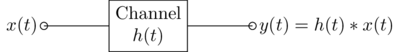

In [10]:
%%tikz
\node (A) at (2,0) [draw,align=center] {Channel\\$h(t)$};
\draw (0,0) node [left] {$x(t)$} circle (2pt) -- (A) -- +(2,0) circle (2pt) node [right] {$y(t)=h(t)*x(t)$};

### Eigenfunctions of the time-invariant channel

The most important property of LTI systems is, that complex exponentials of any frequency are eigenfunctions of the system. Literally, if the input to an LTI system is a complex exponential, its output will be a complex exponential of the same frequency, but with a different amplitude. Let's verify this numerically (here we resort to real-valued functions since they are easier to draw). First, let's define some impulse response of our channel:

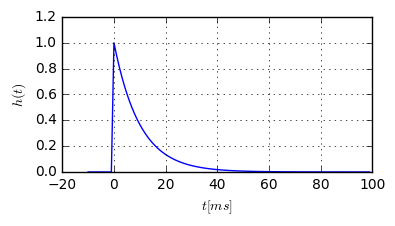

In [3]:
Fs = 1000 # Sampling frequency for discretizing the simulation
t_imp = np.arange(-10e-3, 100e-3, 1/Fs) 
h = np.exp(-0.1*t_imp*1000) * (t_imp >= -0.00001) * (t_imp < 100e-3)
plt.figure(figsize=(4,2));
plt.plot(t_imp*1000, h);
plt.xlabel('$t [ms]$'); plt.ylabel('$h(t)$'); plt.grid(True);

We have defined a causal impulse response, lasting 100ms. Now, let's send some harmonic functions through this system:

In [4]:
%%tikz
\node (A) at (1,0) [draw] {$h(t)$};
\draw (0,0) node [left] {$x(t)=\exp(j2\pi ft)$} circle (2pt) -- (A) -- +(1,0) circle (2pt) node [right] {$y(t)=H(f)\cdot\exp(j2\pi ft)$};

In [14]:
def showEigenfunction(f):
    plt.gcf().clear()
    t = np.arange(-1, 1, 1/Fs)
    x = np.cos(2*np.pi*f*t)
    h = np.exp(-np.arange(10)/2)

    plt.subplot(121)
    plt.plot(t*1000, x)
    plt.xlim((-50,100)); plt.grid(True); plt.xlabel('$t [ms]$'); plt.ylabel('$x(t)$'); plt.ylim((-1.1, 1.3));
    plt.text(0, 1.1, '$f=%.0fHz$' % f, bbox=dict(facecolor='white'))
    
    plt.subplot(122)
    y = np.convolve(h, x)
    y = y[:len(x)]
    plt.plot(t*1000, y)
    plt.xlim((-50,100)); plt.grid(True); plt.xlabel('$t [ms]$'); plt.ylabel('$y(t)=h(t)*x(t)$'); plt.ylim((-3,3))
    plt.tight_layout();
    showInInteract()

In [22]:
interact(showEigenfunction, f=(20,100, 1));

Here, we have numerically verified that the output of the LTI system is a harmonic function with same frequency as the input function. Furthermore, depending on the frequency of the harmonic, the amplitude of the output changes. Mathematically, we can write 

$$y(t)=h(t)*\exp(j2\pi ft)=H(f)\cdot\exp(j2\pi ft).$$

This tells us, that the value $H(f)$ is the eigenvalue of the system, for the eigenfunction $x(t)=\exp(j2\pi ft)$.
It's no coincidence we used the symbol $H(f)$ here, because the eigenvalue is exactly the Fourier transform of the impulse response at the frequency $f$. 

### (Unrealistic) OFDM with infinitely long symbols
We've seen that a complex exponential is not distorted when being transmitted over the channel. Hence, we can encode information in the amplitude of a complex exponential and look at the received amplitude, to recover the information: Let $A$ be the information we want to transmit, we could send $x(t)=A\exp(j2\pi ft)$ over the channel. At the receiver, we have $$y(t)=A\cdot H(f)\cdot\exp(j2\pi ft).$$ When we know $H(f)$, i.e. the channel frequency response at frequency $f$, we can calculate the information $A$. 

Even more, different frequencies do not interfer with each other. So let's transmit two different pieces of information $X_1,X_2$ using two different frequencies $f_1,f_2$:

$$\begin{align}x(t)&=X_1\exp(j2\pi f_1t) + X_2\exp(j2\pi f_2t)\\y(t)&=h(t)*x(t)=X_1\cdot H(f_1)\cdot\exp(j2\pi f_1t)+X_2\cdot H(f_2)\cdot\exp(j2\pi f_2t).\end{align}$$

Even more, let's transmit not only two different pieces of information, but many. For each information, we use a different frequency, and denote the information on frequency $f$ by $X(f)$. Since we can transmit on any frequency, the transmit signal can be written as

$$x(t)=\int_{-\infty}^{\infty}X(f)\exp(j2\pi ft)df.$$

For each frequency $f$, we transmit the information $X(f)$ on the complex exponential $\exp(j2\pi ft)$. You see, this is exactly the **inverse [Fourier Transform](http://dspillustrations.com/pages/posts/misc/properties-of-the-fourier-transform.html)**. 

At the receiver side, the received signal becomes

$$y(t)=\int_{-\infty}^{\infty}X(f)H(f)\exp(j2\pi ft) df,$$

from which we actually want to obtain the amplitudes of the different frequency components $X(f)H(f)$. What do you do to obtain the information about the frequency components of a signal? Right, you perform [Fourier Transform](http://dspillustrations.com/pages/posts/misc/approximating-the-fourier-transform-with-dft.html), which leads to

$$Y(f)=\mathcal{F}\{y(t)\}=X(f)H(f),$$

because $X(f)H(f)$ is the amplitude of the frequency component with frequency $f$. *We have essentially derived the convolution theorem.*

What's the problem with this approach? Well, the involved signals are infinitely long. So, in order to demodulate the signal, you'd need to wait infitinely long. Clearly, that's not a practical solution. 

### Orthogonality of time-limited complex exponentials
What, if we do not want to wait infinitely long at the receiver, but only for a time period of length $T$? Hence, at the receiver we perform the Fourier Transform of a time-limited exponential, let's say which ranges from $0$ to $T$. Hence, given a received signal of frequency $f_1$, by $x(t)=\exp(j2\pi f_1 t)$, what would be the result of the Fourier transform of this signal? Let's use Sympy to do the tedious calculation:

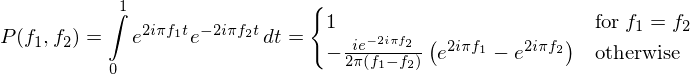

In [16]:
import sympy as S  
S.init_printing()
f1, f2, t, P = S.symbols("f1 f2 t P")
I = S.Integral(S.exp(2*S.I *S.pi*f1*t)*S.exp(-2*S.I*S.pi*f2*t), (t, 0, 1))  # write the integral
R = S.simplify(I.doit())  # calculate the integral
display(S.relational.Eq(S.relational.Eq(P(f1,f2), I), R))  # show the result

The function does not look really nice. One could simplify it, but we dont care at this point. Let's just plot it for different values of $f_1$ and $f_2$ and see what happens:

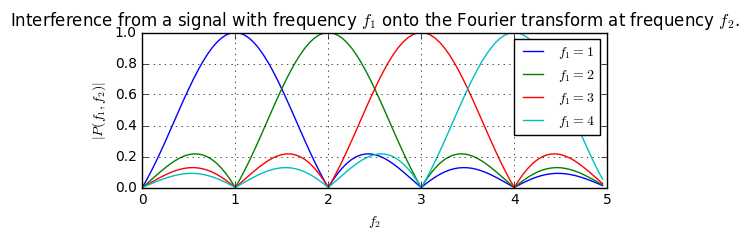

In [18]:
X = np.vectorize(lambda f1, f2: R.evalf(subs=dict(f1=f1,f2=f2)))
plt.figure(figsize=(6,2))
for f1 in (1, 2, 3, 4):
    f2 = np.linspace(0, 5, 100, endpoint=False)
    plt.plot(f2, abs(X(f1, f2)), label='$f_1=%d$' % f1)
plt.legend(fontsize=10); plt.grid(True); plt.xlabel('$f_2$'); plt.ylabel('$|P(f_1,f_2)|$');
plt.title("Interference from a signal with frequency $f_1$ onto the Fourier transform at frequency $f_2$.");

What does this figure show? It tells us, that if we transmit with a frequency of $f_1=1$ (blue curve), the output of the Fourier transform at frequencies $f_2=\{2,3,4,5,...\}$ becomes $0$. Hence, the signal transmitted at frequency $f_1=1$ does not interfer with a signal that was transmitted at a frequency $f_2=\{2,3,4,5\}$. These results hold for $T=1$. In general, it holds that $P(f_1,f_2)=0$ if $f_1-f_2=n/T$ with $n\in\mathbb{Z}$. (*Essentially, what he have derived here is the Fourier transform of a rectangular function of length $T$*.)

In conclusion, if we require that our receiver window should only be $T$ seconds long, we can only transmit signals at the frequencies $1/T, 2/T, 3/T, ...$. The signals on these frequencies are called the OFDM subcarriers and this property ensures the orthogonality, i.e. it ensures that adjacent subcarriers do not interfer with each other after the Fourier transform at the receiver. 

### Influence of the wireless channel
Up to now, everything should be fine, right? We have shown that complex exponentials are orthogonal over a time period $T$, when their frequencies have a difference of $\Delta_f=f_1-f_2=n/T$ with $n\in\mathbb{Z}$. Furthermore, we have stated that complex exponentials are eigenfunctions of the channel, i.e. a transmitted complex exponential remains a complex exponential. So, problem solved?

No, unfortunately not. Only infinitely long complex exponentials are eigenfunctions of the channel. This means, if we transmit a complex exponential of length $T$, the output of the channel will not just be a scaling of the amplitude of this signal:

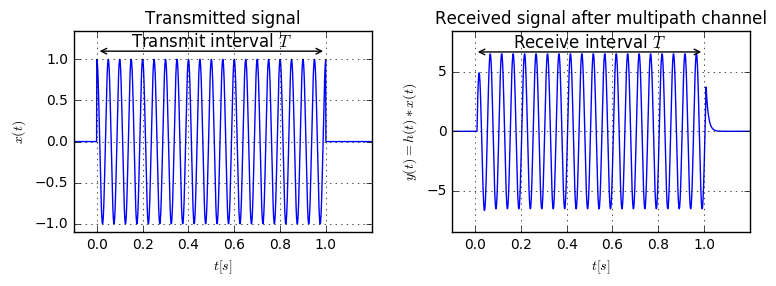

In [20]:
T = 1
t = np.arange(-1, 2, 1/Fs)
f1 = 20
x = np.cos(2*np.pi*f1*t) * (t>=0) * (t<1)
y = np.convolve(h, x)
y = y[:len(x)]

plt.subplot(121)
plt.plot(t, x)
plt.xlim((-0.1, 1.2)); plt.grid(True); plt.xlabel('$t [s]$'); plt.ylabel('$x(t)$'); plt.ylim((-1.1, 1.35)) # ilü
plt.annotate(s='',xy=(0,1.1), xytext=(1,1.1), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5,1.1,r'Transmit interval $T$',va='bottom', ha='center', fontsize=12);
plt.title("Transmitted signal")

plt.subplot(122)
plt.plot(t, y)
plt.xlim((-0.1, 1.2)); plt.grid(True); plt.xlabel('$t [s]$'); plt.ylabel('$y(t)=h(t)*x(t)$'); plt.ylim((-8.5, 8.5))
plt.annotate(s='',xy=(0,6.7), xytext=(1,6.7), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5,6.7,r'Receive interval $T$',va='bottom', ha='center', fontsize=12);
plt.title("Received signal after multipath channel")
plt.tight_layout()

Apparently, at the beginning of the received interval, the signal is severely distorted. This would lead to a non-accurate signal reception. Hence, this technique is not applicable in a multpath channel. What can we do?

*Even though it looks like the signal is also distorted at the end of receive interval, this is not the case: The channel introduces a delay to the harmonic function, shifting the wave slightly to the right, hence the wave won't reach its maximum at $t=1$. This is due to the [phase delay](http://dspillustrations.com/pages/posts/misc/group-delay-and-phase-delay-example.html) of the channel.*

### The Necessity of the Cyclic Prefix
We know the received signal is the convolution of the channel's impulse response with the transmitted signal and only infinitely long complex exponentials are eigenfunctions of the channel. But, we want to have time-limited complex exponentials at the output of the channel. 

Knowing that the channel impulse response has length $L$, we know that the channel output at time $t_0$ does only depend on the channel input at times $t_0-L\leq t\leq t_0$, i.e. the channel does have a limited memory, it can only remember the last $L$ seconds of the input signal. Consequently, the channel does not care, if the input signal is an infinitely long complex exponential or not, it only cares about the last $L$ seconds of the signal. Therefore, we can trick the channel by transmitting a complex exponential of length $T+L$, and the channel will output a perfect complex exponential during the times $L\leq t\leq T+L$:

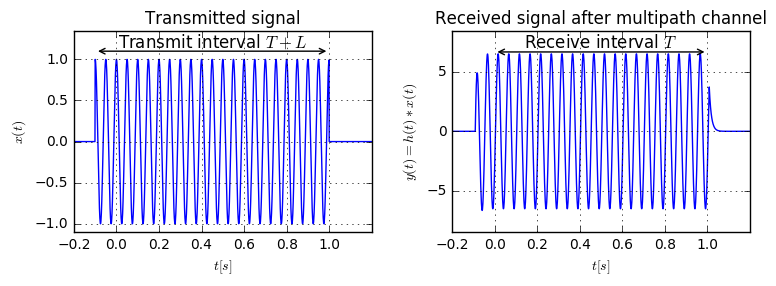

In [21]:
L = 0.1 # the channel length
x = np.cos(2*np.pi*f1*t) * (t>=-L) * (t<T)
y = np.convolve(h, x)[:len(x)]

plt.subplot(121)
plt.plot(t, x)
plt.xlim((-0.2, 1.2)); plt.grid(True); plt.xlabel('$t [s]$'); plt.ylabel('$x(t)$'); plt.ylim((-1.1, 1.35))
plt.annotate(s='',xy=(-L,1.1), xytext=(1,1.1), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5-L/2,1.1,r'Transmit interval $T+L$',va='bottom', ha='center', fontsize=12);
plt.title("Transmitted signal")

plt.subplot(122)
plt.plot(t, y)
plt.xlim((-0.2, 1.2)); plt.grid(True); plt.xlabel('$t [s]$'); plt.ylabel('$y(t)=h(t)*x(t)$'); plt.ylim((-8.5, 8.5))
plt.annotate(s='',xy=(0,6.7), xytext=(1,6.7), arrowprops=dict(arrowstyle='<->'))
plt.text(0.5,6.7,r'Receive interval $T$',va='bottom', ha='center', fontsize=12);
plt.title("Received signal after multipath channel")
plt.tight_layout()

As we see, now the distortion of the transmitted signal occurs outside of the receiver interval. Within the receiver interval the waves are perfect. Hence, within this interval our orthogonality condition holds and we can detect our data without interference. 

You might have already guessed that the extra part at the beginning of the block is called the [*Cyclic prefix*](http://dspillustrations.com/pages/posts/misc/the-cyclic-prefix-cp-in-ofdm.html). Some people call it *guard interval*, which seems more appropriate to our current application: It guards the actual receiver interval such that it contains a perfect harmonic function. Why is it also called *Cyclic prefix*? We know that the complex exponentials with frequencies $1/T, 2/T, \dots$ are periodic with period $T$. Therefore, the we have $x(t-T)=x(t)$, which shows that the guard interval is actually a copy of the end of the block. Therefore, it's called cyclic prefix (CP), because the CP creates a cyclic block structure by prepneding the end of the block to its beginning.

### Relation to coherence bandwidth, intersymbol interference and flat fading per carrier
Often, OFDM is motivated as follows:

A single stream of high data rate requires very short symbols and a large bandwidth. Therefore, in a multipath channel these short symbols would be subject to intersymbol interference (or equivalently, since the transmitter bandwidth is very large, it suffers from frequency-selective fading of the multipath channel). This makes equalization difficult. 

The proposed solution of OFDM is to divide this single high-rate stream into several parralel low-rate streams. These streams have therefore longer symbols and smaller bandwidth. Accordingly, the multipath channel would not create intersymbol interference, since the symbols experience only flat fading (i.e. no frequency-selective fading) due to the small bandwidth of each stream. It is further argued, that the [coherence bandwidth](https://en.wikipedia.org/wiki/Coherence_bandwidth) of the channel needs to be larger than the subcarrier bandwidth to achieve flat fading.

Even though in principle the above argumentation appears correct, it is very superficial: It does not explain the use of the CP and also, it bases on the vague definition of the coherence bandwidth (*there is no numerically exact definition of this measure and literature is contradicting*). In particular, we know that regardless of the symbol duration, a multipath channel will always introduce intersymbol interference. However, the impact of ISI can be reduced with longer symbols. Also, a multipath channel is nowhere flat, and the flatness of each subcarrier is another approximation in the argumentation. Lastly, the orthogonality between the carriers and the required subcarrier distance cannot be explained by above description.

The OFDM system is more exactly described by the formulation in this article, where we have started from the basic properties of the channel to design a system that achieves orthogonality. We did not rely on coherence bandwidth or data rate etc. As long as the CP is longer than the channel impulse response, the system works, regardless of the vague definition of its coherence bandwidth and so on.

### Summary
> - OFDM exploits the **convolution theorem** of the Fourier transform.
> - In order to have a time-limited receiver window of length $T$, not all frequencies can be used, but only the frequencies $1/T, 2/T, 3/T, \ldots$. This choice ensures orthogonality between the carriers. 
> - The **cyclic prefix / guard interval** ensures that the signal within the receiver window is a perfect harmonic function, by guarding the receiver window from the transient response of the channel.